In [391]:
import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader
import deepchem as dc
from rdkit import Chem
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data, InMemoryDataset
import random
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [392]:
import random
random_state = 42
random.seed(random_state)
torch.manual_seed(random_state)
np.random.seed(random_state)

In [ ]:
import os
import shutil

# Get the current working directory (where the script is running)
base_path = os.getcwd()
# Go one level up from the base path
parent_path = os.path.dirname(os.path.dirname(base_path))
# Define paths for the 'data/ARGA' folder and the new subfolders
data_path = os.path.join(parent_path, "data")
gae_data_path = os.path.join(data_path, "ARGA")
logistic_eq_path = os.path.join(gae_data_path, "logistic equation")
rule_of_three_path = os.path.join(gae_data_path, "rule of three")
fragrance_like_property = os.path.join(gae_data_path, "fragrance_like_property")
GDB_criteria = os.path.join(gae_data_path, "GDB Criteria")
if os.path.exists(gae_data_path):
    shutil.rmtree(gae_data_path)
    print(f"Deleted folder: {gae_data_path}")
else:
    print(f"Folder does not exist: {gae_data_path}")
# Create 'data' directory if it doesn't exist
os.makedirs(data_path, exist_ok=True)

# Create 'ARGA' directory under 'data' if it doesn't exist
os.makedirs(gae_data_path, exist_ok=True)

# Create empty subfolders "logistic equation" and "GDB Criteria" under "ARGA"
os.makedirs(logistic_eq_path, exist_ok=True)
os.makedirs(rule_of_three_path, exist_ok=True)
os.makedirs(fragrance_like_property, exist_ok=True)
os.makedirs(GDB_criteria, exist_ok=True)
print(f"Created folder structure:")
print(f"  {data_path}")
print(f"  {gae_data_path}")
print(f"  {logistic_eq_path}")
print(f"  {rule_of_three_path}")
print(f"  {fragrance_like_property}")

In [394]:
# class DeepChemToPyGDataset(InMemoryDataset):
#     def __init__(self, data_list, transform=None):
#         super(DeepChemToPyGDataset, self).__init__('.', transform, None, None)
#         self.data, self.slices = self.collate(data_list)

#     def get(self, idx):
#         return super().get(idx)

In [395]:
from torch_geometric.data import InMemoryDataset, Data

class DeepChemToPyGDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        """
        Converts a list of PyG `Data` objects into an InMemoryDataset.
        
        Args:
            data_list (list of Data): List of PyG Data objects.
            transform (callable, optional): Optional transform applied to each data object.
        """
        super(DeepChemToPyGDataset, self).__init__('.', transform, None, None)
        self.data, self.slices = self.collate(data_list)

    def get(self, idx):
        """
        Retrieves the data object at the specified index.
        """
        return super().get(idx)


In [ ]:

#pyg_dataset = torch.load('../../data/curated dataset/my_dataset.pth')
# pyg_dataset = torch.load('../../data/curated dataset/frag_pyg_dataset.pth')
pyg_dataset = torch.load(r'C:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\Convertors\cleaned_frag_pyg_dataset.pth')

In [ ]:
len(pyg_dataset)

In [398]:
# Set up hyperparameters
node_features = pyg_dataset[0].x.shape[1]  # Should be 134 based on your description
edge_features = pyg_dataset[0].edge_attr.shape[1]  # Should be 6 based on your description

hidden_dim = 192
latent_dim = 64
lr=0.001258
num_epochs = 60

batch_size = 8
patience = 10
#no of layers





In [ ]:
# Create data loader
loader = DataLoader(pyg_dataset, batch_size=batch_size, shuffle=True)

In [400]:
#experimental
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

class ARGA(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, latent_dim, dropout=0.2):
        super(ARGA, self).__init__()
        self.encoder = Encoder(node_features, edge_features, hidden_dim, latent_dim, dropout)
        self.decoder = Decoder(latent_dim, hidden_dim, node_features, edge_features)
        self.discriminator = Discriminator(latent_dim, hidden_dim)
        
    def encode(self, x, edge_index, edge_attr, batch=None):
        return self.encoder(x, edge_index, edge_attr, batch)

    def decode(self, z, edge_index, batch=None):
        return self.decoder(z, edge_index, batch)

    def discriminate(self, z):
        return self.discriminator(z)

    def forward(self, x, edge_index, edge_attr, batch=None):
        z, mu = self.encode(x, edge_index, edge_attr, batch)
        reconstructed_x, reconstructed_edge_attr = self.decode(z, edge_index, batch)
        return reconstructed_x, reconstructed_edge_attr, z

    def generate_multiple_outputs(self, x, edge_index, edge_attr, batch=None, num_samples=5, variator=0.1):
        outputs = []
        with torch.no_grad():
            z, mu = self.encode(x, edge_index, edge_attr, batch)
            for _ in range(num_samples):
                epsilon = torch.randn_like(mu) * variator
                z_new = mu + epsilon
                reconstructed_x, reconstructed_edge_attr = self.decode(z_new, edge_index, batch)
                outputs.append((reconstructed_x, reconstructed_edge_attr, edge_index))
        return outputs

class Encoder(nn.Module):
    def __init__(self, node_features, edge_features, hidden_dim, latent_dim, dropout):
        super(Encoder, self).__init__()
        self.edge_encoder = nn.Linear(edge_features, hidden_dim)
        self.conv1 = SAGEConv(node_features + hidden_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr, batch=None):
        edge_attr = torch.clamp(edge_attr, -5, 5)
        edge_attr = F.relu(self.edge_encoder(edge_attr))
        edge_attr = self.dropout(edge_attr)
        
        edge_attr_expanded = torch.zeros((x.size(0), edge_attr.size(1)), device=x.device)
        edge_attr_expanded[edge_index[0]] = edge_attr
        
        x = torch.cat([x, edge_attr_expanded], dim=1)
        x = torch.clamp(x, -5, 5)
        
        h1 = self.conv1(x, edge_index)
        h1 = self.layer_norm1(h1)
        h1 = F.relu(h1)
        h1 = self.dropout(h1)
        
        h2 = self.conv2(h1, edge_index)
        h2 = self.layer_norm2(h2)
        h2 = F.relu(h2)
        h2 = self.dropout(h2)
        
        if batch is not None:
            h2 = global_mean_pool(h2, batch)
        
        mu = self.fc_mu(h2)
        log_var = self.fc_var(h2)
        log_var = torch.clamp(log_var, -10, 2)
        
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return z, mu

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, node_features, edge_features):
        super(Decoder, self).__init__()
        self.node_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_features)
        )
        
        self.edge_decoder = nn.Sequential(
            nn.Linear(latent_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, edge_features)
        )

    def forward(self, z, edge_index, batch=None):
        if batch is not None:
            z = z[batch]
        
        reconstructed_x = self.node_decoder(z)
        
        row, col = edge_index
        edge_h = torch.cat([z[row], z[col]], dim=1)
        reconstructed_edge_attr = self.edge_decoder(edge_h)
        
        return reconstructed_x, reconstructed_edge_attr

class Discriminator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

def train_arga_with_early_stopping(model, train_loader, val_loader, num_epochs, lr=0.0001, device='cuda', patience=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            reconstructed_x, reconstructed_edge_attr, z = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            
            recon_loss = F.mse_loss(reconstructed_x, batch.x) + F.mse_loss(reconstructed_edge_attr, batch.edge_attr)
            
            real_z = torch.randn_like(z)
            real_scores = model.discriminate(real_z)
            fake_scores = model.discriminate(z)
            
            adv_loss = -torch.mean(torch.log(torch.clamp(fake_scores, 1e-6, 1.0)) + 
                                 torch.log(torch.clamp(1 - real_scores, 1e-6, 1.0)))
            
            loss = recon_loss + 1 * adv_loss
            
            if not torch.isnan(loss) and not torch.isinf(loss):
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                total_loss += loss.item()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                reconstructed_x, reconstructed_edge_attr, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
                val_loss += (F.mse_loss(reconstructed_x, batch.x) + 
                           F.mse_loss(reconstructed_edge_attr, batch.edge_attr)).item()
        
        val_loss /= len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break
    
    return model



In [401]:
from torch.utils.data import random_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ARGA model
model = ARGA(node_features, edge_features, hidden_dim=hidden_dim, latent_dim=latent_dim)
train_ratio = 0.8
num_train = int(len(pyg_dataset) * train_ratio)
num_valid = len(pyg_dataset) - num_train
train_dataset, valid_dataset = random_split(pyg_dataset, [num_train, num_valid])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)




In [402]:
trained_model = train_arga_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    lr=lr,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    patience=patience
)


Epoch 1/60, Loss: 0.1464, Val Loss: 0.0873
Epoch 2/60, Loss: 0.0902, Val Loss: 0.0871
Epoch 3/60, Loss: 0.0896, Val Loss: 0.0870
Epoch 4/60, Loss: 0.0893, Val Loss: 0.0868
Epoch 5/60, Loss: 0.0892, Val Loss: 0.0864
Epoch 6/60, Loss: 0.0889, Val Loss: 0.0864
Epoch 7/60, Loss: 0.0888, Val Loss: 0.0865
Epoch 8/60, Loss: 0.0889, Val Loss: 0.0865
Epoch 9/60, Loss: 0.0887, Val Loss: 0.0862
Epoch 10/60, Loss: 0.0887, Val Loss: 0.0861
Epoch 11/60, Loss: 0.0884, Val Loss: 0.0861
Epoch 12/60, Loss: 0.0886, Val Loss: 0.0861
Epoch 13/60, Loss: 0.0886, Val Loss: 0.0860
Epoch 14/60, Loss: 0.0885, Val Loss: 0.0862
Epoch 15/60, Loss: 0.0884, Val Loss: 0.0862
Epoch 16/60, Loss: 0.0886, Val Loss: 0.0861
Epoch 17/60, Loss: 0.0885, Val Loss: 0.0860
Epoch 18/60, Loss: 0.0938, Val Loss: 0.0860
Epoch 19/60, Loss: 0.0885, Val Loss: 0.0860
Epoch 20/60, Loss: 0.0883, Val Loss: 0.0860
Epoch 21/60, Loss: 0.0884, Val Loss: 0.0861
Epoch 22/60, Loss: 0.0884, Val Loss: 0.0860
Epoch 23/60, Loss: 0.0886, Val Loss: 0.08

In [403]:
model=trained_model

In [404]:


# model = ARGA(node_features, edge_features, hidden_dim, latent_dim)


# model = train_arga(model, pyg_dataset, num_epochs, batch_size, lr, device='cpu')
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=6, verbose=True)



In [405]:
# Training loop
# model.train()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# for epoch in range(epochs):
#     total_loss = 0
#     for batch in loader:
#         optimizer.zero_grad()
#         x = batch.x.to(device)
#         edge_index = batch.edge_index.to(device)
#         edge_attr = batch.edge_attr.to(device)
#         recon_x, recon_edge_attr = model(x, edge_index, edge_attr)
#         loss = loss_function(recon_x, x, recon_edge_attr, edge_attr)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     avg_loss = total_loss / len(loader)
#     print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

#     # Scheduler step based on validation loss
#     scheduler.step(avg_loss)

# # Save the trained model
# torch.save(model.state_dict(), 'autoencoder_model.pth')

In [406]:
# checkpoint=torch.load('autoencoder_model.pth')

Node Attribute Convertor

In [407]:
#@title Node Attribute Convertor
'''
Convert one hot encdoing of node feautres to original values.
Lee et al. "A principal odor map unifies diverse tasks in olfactory perception." 
https://www.science.org/doi/10.1126/science.ade4401
'''

def decode_node_attributes(node_vector):
    # Define the ranges and options for each attribute type
    valence_range = list(range(7)) + ['EXCEPTIONAL']
    degree_range = list(range(6)) + ['EXCEPTIONAL']
    num_hydrogens_range = list(range(5)) + ['EXCEPTIONAL']
    formal_charge_range = [-1, -2, 1, 2, 0, 'EXCEPTIONAL']
    atomic_num_range = list(range(1, 101)) + ['EXCEPTIONAL']
    hybridization_options = ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'EXCEPTIONAL']

    # Split the node vector into its component parts
    valence = node_vector[:8]
    degree = node_vector[8:15]
    num_hydrogens = node_vector[15:21]
    formal_charge = node_vector[21:27]
    atomic_num = node_vector[27:128]
    hybridization = node_vector[128:]

    # Decode each attribute
    decoded_attributes = {
        'Valence': valence_range[np.argmax(valence)],
        'Degree': degree_range[np.argmax(degree)],
        'Number_of_Hydrogens': num_hydrogens_range[np.argmax(num_hydrogens)],
        'Formal_Charge': formal_charge_range[np.argmax(formal_charge)],
        'Atomic_Number': atomic_num_range[np.argmax(atomic_num)],
        'Hybridization': hybridization_options[np.argmax(hybridization)]
    }

    return decoded_attributes

def decode_node_matrix(node_matrix):
    return [decode_node_attributes(node) for node in node_matrix]




In [408]:
temp = pyg_dataset[0]
temp

Data(x=[5, 134], edge_index=[2, 8], edge_attr=[8, 6], y=[138])

Edge Attributes Convertor

In [409]:
#@title Edge Attributes Convertor

'''
This converts the edge attributes to the original values as per concerned olfaction literature.
Lee et al. "A principal odor map unifies diverse tasks in olfactory perception." 
https://www.science.org/doi/10.1126/science.ade4401
'''

def decode_edge_attributes(edge_vector):
    # Define the options for bond type, with EXCEPTIONAL as the first option
    bond_types = ["EXCEPTIONAL", "single", "double", "triple", "aromatic"]

    # Split the edge vector into its component parts
    bond_type = edge_vector[:5]  # Now we have 5 options for bond type
    is_in_ring = edge_vector[5]  # The 'Is in Ring' boolean is now the 6th element

    # Decode each attribute
    decoded_attributes = {
        'Bond_Type': bond_types[np.argmax(bond_type)],
        'Is_in_Ring': bool(is_in_ring)
    }

    return decoded_attributes

def decode_edge_matrix(edge_matrix):
    return [decode_edge_attributes(edge) for edge in edge_matrix]

In [410]:

encoded_representations = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure your model is on the correct device
model = model.to(device)
for i in pyg_dataset:
    temp = i
    x = temp.x.to(device)
    edge_index = temp.edge_index.to(device)
    edge_attr = temp.edge_attr.to(device)
    z, _ = model.encode(x, edge_index, edge_attr)
    #z,_ = model.encode(temp.x , temp.edge_index , temp.edge_attr)
    encoded_representations.append(z.cpu().detach().numpy())
    #encoded_representations.append(z.detach().numpy())


In [411]:
len(encoded_representations)

4751

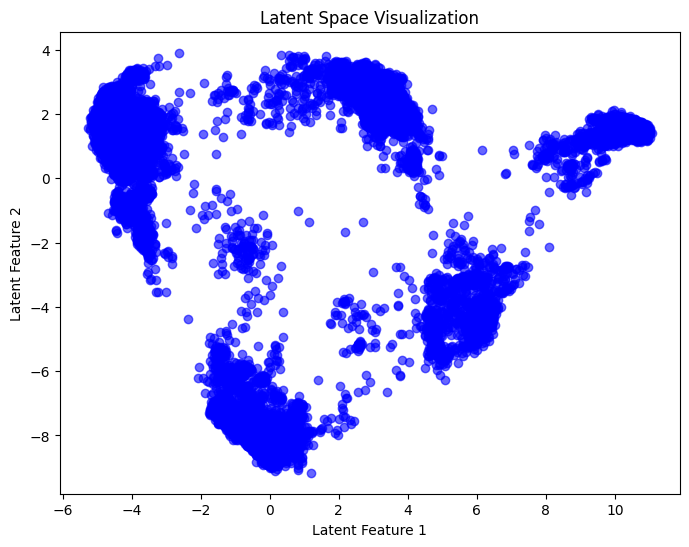

In [412]:
# Perform PCA for dimensionality reduction (if latent_dim > 2)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
encoded_representations = np.concatenate(encoded_representations, axis=0)
if latent_dim > 2:
    pca = PCA(n_components=2)
    encoded_representations = pca.fit_transform(encoded_representations)

# Plot the latent space
plt.figure(figsize=(8, 6))
plt.scatter(encoded_representations[:, 0], encoded_representations[:, 1], c='b', marker='o', alpha=0.6)
plt.title('Latent Space Visualization')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.show()

In [413]:
from tqdm import tqdm  # For progress bar

# Ensure the model is in evaluation mode
model.eval()

# List to store all generated outputs
all_generated_outputs = []

# Number of samples per molecule
num_samples = 5

# Counter for successful generations
successful_generations = 0


VARIATOR = 8



# Iterate through the entire dataset
with torch.no_grad():
    for i in tqdm(range(len(pyg_dataset)), desc="Generating molecules"):
        try:
            batch = pyg_dataset[i]
            x, edge_index, edge_attr = batch.x.to(device), batch.edge_index.to(device), batch.edge_attr.to(device)
            
            # Generate multiple outputs for this molecule
            generated_outputs = model.generate_multiple_outputs(x, edge_index, edge_attr, num_samples=num_samples, variator = VARIATOR)
            
            # Extend the list with the generated outputs
            all_generated_outputs.extend(generated_outputs)
            successful_generations += 1
        except RuntimeError as e:
            print(f"Error processing molecule {i}: {str(e)}")
            continue

print(f"Successfully generated samples for {successful_generations} out of {len(pyg_dataset)} molecules.")
print(f"Total number of generated molecules: {len(all_generated_outputs)}")

Generating molecules: 100%|██████████| 4751/4751 [00:11<00:00, 403.00it/s]

Successfully generated samples for 4751 out of 4751 molecules.
Total number of generated molecules: 23755


Creating RDKit Molecule

In [414]:
from rdkit import Chem
from rdkit.Chem import rdchem

def create_rdkit_mol(node_attributes, edge_index, edge_attributes):
    mol = Chem.RWMol()

    hybridization_map = {
        'SP': rdchem.HybridizationType.SP,
        'SP2': rdchem.HybridizationType.SP2,
        'SP3': rdchem.HybridizationType.SP3,
        'SP3D': rdchem.HybridizationType.SP3D,
        'SP3D2': rdchem.HybridizationType.SP3D2
    }

    # Add atoms
    for node in node_attributes:
        atomic_num = node['Atomic_Number']
        atom = Chem.Atom(atomic_num)

        # Convert formal charge to integer if necessary
        formal_charge = int(node.get('Formal_Charge'))
        atom.SetFormalCharge(formal_charge)

        hybridization = hybridization_map.get(node['Hybridization'], rdchem.HybridizationType.UNSPECIFIED)
        atom.SetHybridization(hybridization)

        # Add atom to the molecule
        mol_idx = mol.AddAtom(atom)

        # Handle the Number_of_Hydrogens conversion with a fallback for invalid values
        try:
            num_hydrogens = int(node.get('Number_of_Hydrogens', 0))
        except ValueError:
            print(f"Invalid Number_of_Hydrogens value for node with atomic number {atomic_num}: {node.get('Number_of_Hydrogens')}. Setting to 0.")
            num_hydrogens = 0

        mol.GetAtomWithIdx(mol_idx).SetNumExplicitHs(num_hydrogens)

    # Add bonds
    for [i, j], edge in zip(edge_index, edge_attributes):
        bond_type = rdchem.BondType.SINGLE
        if edge['Bond_Type'] == 'double':
            bond_type = rdchem.BondType.DOUBLE
        elif edge['Bond_Type'] == 'triple':
            bond_type = rdchem.BondType.TRIPLE
        elif edge['Bond_Type'] == 'aromatic':
            bond_type = rdchem.BondType.AROMATIC
        if mol.GetBondBetweenAtoms(int(i), int(j)) is None:
            mol.AddBond(int(i), int(j), bond_type)

    # Sanitize the molecule
    try:
        Chem.SanitizeMol(mol)
    except ValueError as e:
        print(f"Warning: Couldn't sanitize molecule: {e}")

    return mol

def mol_to_smiles(mol):
    if mol is not None:
        return Chem.MolToSmiles(mol, canonical=True)
    return None



To deal with condition which go unnoticed in sanitize phase

In [415]:
from rdkit import Chem
from rdkit.Chem import SanitizeMol, AtomValenceException, KekulizeException
def is_strictly_valid_smiles(smiles: str) -> bool:
    """
    Validate the SMILES string with stringent checks using RDKit.

    Parameters:
        smiles (str): SMILES string to validate.

    Returns:
        bool: True if the SMILES string passes all stringent checks, False otherwise.
    """
    # Step 1: Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False  # Invalid SMILES syntax

    # Step 2: Sanitize molecule (checks for valence, bond types, etc.)
    try:
        SanitizeMol(mol)
    except (AtomValenceException, KekulizeException):
        return False  # Invalid molecule due to bad valence or kekulization issues

    # Step 5: Simple valence check
    allowed_valences = {
        1: [1],  #Hydrogen
        6: [4],    # Carbon
        7: [-3, -2, -1, 0, +1, +2, +3, +4, +5], # Nitrogen
        8: [-2, -1, -0.5, 0, +1, +2],    # Oxygen
        15: [3, 5], # Phosphorus
        16: [-2, -1, 0, +1, +2, +3, +4, +5, +6], # Sulfur
        9: [-1,0,+1],    # Fluorine
        17: [	-1, 0, +1, +3, +4, +5, +7],   # Chlorine
        35: [-1, 0, +1, +3, +4, +5, +7],   # Bromine
        53: [-1, 0, +1, +3, +5, +7],   # Iodine
        85: [-1, 0, +1, +3, +5, +7], #Astatine
    }

    for atom in mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        valence = atom.GetTotalValence()
        
        if atomic_num in allowed_valences:
            if valence not in allowed_valences[atomic_num]:
                return False
        else:
            # For other elements, use RDKit's default valence
            default_valence = Chem.GetPeriodicTable().GetDefaultValence(atomic_num)
            if valence > default_valence:
                return False

    return True  # All checks passed


In [416]:
import os
import sys
from tqdm import tqdm
import rdkit
from rdkit import RDLogger
import warnings
from contextlib import contextmanager

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

generated_smiles = []


In [417]:
from tqdm import tqdm
import warnings

# Initialize an empty set for unique SMILES
unique_smiles_set = set()
generated_smiles = []

for i in tqdm(all_generated_outputs, desc="Processing generated outputs"):
    recon_x, recon_edge_attr, edge_index = i

    # Move tensors to CPU and convert to numpy
    edge_index = edge_index.cpu().t().numpy()[::2]
    node_vector = recon_x.cpu().detach().numpy()
    decoded_nodes = decode_node_matrix(node_vector)
    edge_vector = recon_edge_attr.cpu().detach().numpy()[::2]
    decoded_edges = decode_edge_matrix(edge_vector)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with suppress_stdout():
            try:
                retries = 0
                max_retries = 15  # Maximum attempts to generate a unique SMILES
                while retries < max_retries:
                    mol = create_rdkit_mol(decoded_nodes, edge_index, decoded_edges)
                    smiles = mol_to_smiles(mol)
                    
                    if smiles:  # Check if SMILES generation was successful
                        if smiles not in unique_smiles_set:
                            generated_smiles.append(smiles)
                            unique_smiles_set.add(smiles)
                            break  # Exit the retry loop on success
                        else:
                            print(f"Duplicate SMILES detected: {smiles}")
                    else:
                        print("Warning: Generated an empty SMILES string.")
                    
                    retries += 1
                else:
                    print("Failed to generate a unique SMILES after retries.")
            except Exception as e:
                print(f"Error generating SMILES for the molecule: {e}")
                continue

print(f"Total unique generated SMILES: {len(generated_smiles)}")
if generated_smiles:
    print(f"First SMILES: {generated_smiles[0]}")


Processing generated outputs: 100%|██████████| 23755/23755 [00:12<00:00, 1899.39it/s]

Total unique generated SMILES: 23657
First SMILES: C[CH3]O(C)S


In [418]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
# Convert SMILES strings to RDKit molecules (filter out invalid ones)
molecules = [Chem.MolFromSmiles(smiles) for smiles in generated_smiles]
valid_molecules = [mol for mol in molecules if mol is not None]
len(valid_molecules)

597

c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


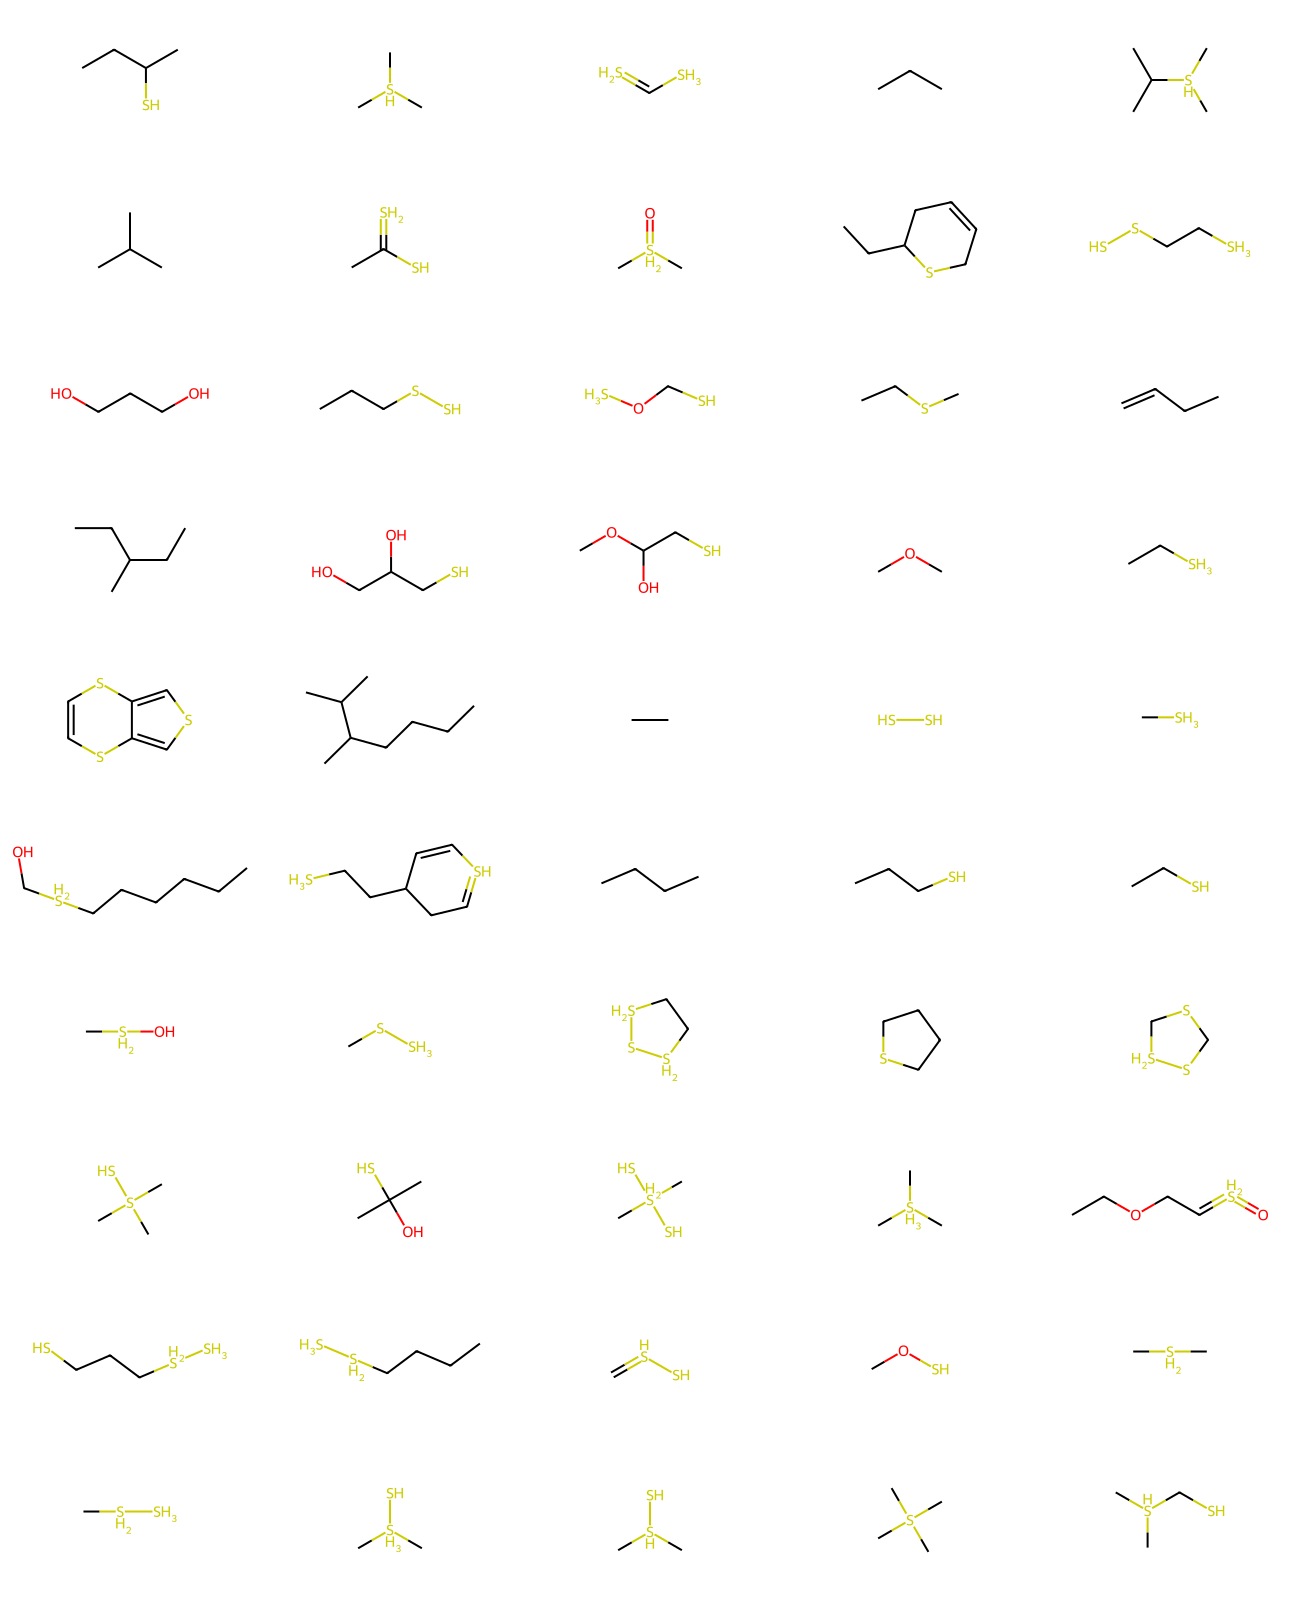

In [419]:
from rdkit.Chem.Draw import MolsToGridImage

# Generate SMILES for each molecule
unique_smiles = set()
unique_molecules = []

for mol in valid_molecules:
    smiles = Chem.MolToSmiles(mol,canonical=True)
    if smiles not in unique_smiles:
        unique_smiles.add(smiles)
        unique_molecules.append(mol)
# Create the grid image with unique molecules
grid_image = MolsToGridImage(
    unique_molecules, molsPerRow=5, subImgSize=(260, 160)
)


# Display the grid image
grid_image

In [420]:
def smiles_to_canonical(smiles_list):
    canonical_smiles = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)  # Convert SMILES to molecule
        if mol is not None:
            canonical_smile = Chem.MolToSmiles(mol, canonical=True)  # Convert back to canonical SMILES
            canonical_smiles.append(canonical_smile)
        else:
            canonical_smiles.append(None)  # Handle invalid SMILES
    return canonical_smiles

In [421]:
# Load the first column of the CSV as canonical SMILES
# original_dataset = smiles_to_canonical(pd.read_csv('../../data/curated dataset/curated_GS_LF_merged_4983.csv').iloc[:, 0].tolist())
original_dataset = smiles_to_canonical(pd.read_csv(r'C:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\curated dataset\curated_GS_LF_merged_cleaned.csv').iloc[:, 0].tolist())
generated_smiles_canonical = smiles_to_canonical(generated_smiles)

# Remove None values (invalid SMILES) if needed
valid_generated_smiles_canonical = [smile for smile in generated_smiles_canonical if smile is not None]
generated_smiles=valid_generated_smiles_canonical
print(len(original_dataset))
print(len(generated_smiles))

4751
597


In [422]:
# Check validity of generated and original SMILES
valid_generated_smiles = [smiles for smiles in generated_smiles if is_strictly_valid_smiles(smiles)]
valid_original_smiles = [smiles for smiles in original_dataset if is_strictly_valid_smiles(smiles)]

print("Percent of valid in original :" ,len(valid_original_smiles)/len(original_dataset))
print("Percent of valid in generated :" ,len(valid_generated_smiles)/len(generated_smiles))

Percent of valid in original : 1.0
Percent of valid in generated : 1.0


In [423]:
#Function created to remove SMILES present in valid_original_smiles from valid_generated_smiles
def filter_generated_smiles(valid_generated_smiles, valid_original_smiles):
    
    # Convert lists to sets
    set_generated = set(valid_generated_smiles)
    set_original = set(valid_original_smiles)
    
    # Find the difference
    filtered_set = set_generated - set_original
    
    # Convert the result back to a list
    filtered_list = list(filtered_set)
    
    return filtered_list

In [424]:
filtered_generated_smiles = filter_generated_smiles(valid_generated_smiles, valid_original_smiles)
print("Filtered Generated SMILES:", len(filtered_generated_smiles))

Filtered Generated SMILES: 556


In [425]:
import requests
import pandas as pd
def check_in_pubchem(smiles):
    """
    Checks if the given SMILES string is in PubChem using the PUG-REST API.
    Returns True if the SMILES is found in PubChem, False otherwise.
    
    Args:
        smiles (str): A SMILES string representing a chemical compound
        
    Returns:
        bool: True if found in PubChem, False otherwise
    """
    # Use PubChem PUG-REST API to search for compound by SMILES
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/cids/TXT"
    response = requests.get(url)
    
    # If the response has content, it means the SMILES was found
    if response.status_code == 200 and response.text.strip():
        return True
    return False

In [426]:
from tqdm import tqdm

def filter_pubchem_smiles(smiles_list):
    """
    Filter a list of SMILES strings to keep only those found in PubChem.
    Shows progress using tqdm.
    
    Args:
        smiles_list (list): List of SMILES strings to check
        
    Returns:
        list: Filtered list containing only SMILES found in PubChem
    """
    filtered_smiles = []
    
    for smile in tqdm(smiles_list, desc="Checking PubChem"):
        try:
            if check_in_pubchem(smile):
                filtered_smiles.append(smile)
        except Exception as e:
            print(f"Error checking SMILES {smile}: {str(e)}")
            continue
            
    return filtered_smiles


In [427]:
print("Count before PubChem:", len(filtered_generated_smiles))
filtered_generated_smiles = filter_pubchem_smiles(filtered_generated_smiles)
print('Count after Pubchem:' ,len(filtered_generated_smiles))

Count before PubChem: 556


Checking PubChem: 100%|██████████| 556/556 [15:52<00:00,  1.71s/it]

Count after Pubchem: 139


In [428]:
from rdkit.Chem import Draw
import io
from PIL import Image
from io import BytesIO
#display first 60 molecules generated
mols = [Chem.MolFromSmiles(smiles) for smiles in filtered_generated_smiles[:60]]
img = Draw.MolsToGridImage(mols, molsPerRow=9, subImgSize=(200, 200))
img_buffer = io.BytesIO(img.data)

# Open the image using PIL
img_pil = Image.open(img_buffer)

# Directory to save images
output_dir = "../../figures/ARGA/Sample Molecules Generated/"

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Save the image in different DPI resolutions
for dpi in [300, 600, 1200]:
    output_path = os.path.join(output_dir, f"sample_molecules_{dpi}dpi.png")
    img_pil.save(output_path, dpi=(dpi, dpi))
    print(f"Image saved at {output_path} with {dpi} DPI.")

c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


Image saved at ../../figures/ARGA/Sample Molecules Generated/sample_molecules_300dpi.png with 300 DPI.
Image saved at ../../figures/ARGA/Sample Molecules Generated/sample_molecules_600dpi.png with 600 DPI.
Image saved at ../../figures/ARGA/Sample Molecules Generated/sample_molecules_1200dpi.png with 1200 DPI.


In [429]:
import csv

# Example list
data_list = filtered_generated_smiles

file_name = "../../data/ARGA/filtered_generated_smiles.csv"
with open(file_name, mode="w", newline="") as file:
    writer = csv.writer(file)
    
    # Write the header
    writer.writerow(["SMILE"])
    
    # Write each item in the list as a new row
    for item in data_list:
        writer.writerow([item])

print(f"List saved to {file_name} with the first column named 'SMILE'")
print("Files created:")
print(f"1. filtered_generated_smiles.csv")

List saved to ../../data/ARGA/filtered_generated_smiles.csv with the first column named 'SMILE'
Files created:
1. filtered_generated_smiles.csv


In [430]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np
from tqdm import tqdm  # For progress tracking
import pandas as pd
def calculate_diversity(smiles_list):
    """
    Calculate the diversity score for a list of SMILES strings.

    Parameters:
    - smiles_list: List of SMILES strings.

    Returns:
    - diversity_score: A value representing the diversity of the dataset.
    """
    try:
        # Generate fingerprints for all molecules
        fingerprints = []
        for smiles in tqdm(smiles_list, desc="Generating fingerprints"):
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
                fingerprints.append(fp)
            else:
                print(f"Invalid SMILES skipped: {smiles}")
        
        # Calculate pairwise Tanimoto similarities
        num_fps = len(fingerprints)
        if num_fps < 2:
            print("Not enough valid molecules to calculate diversity.")
            return 0.0

        similarities = []
        for i in tqdm(range(num_fps), desc="Calculating similarities"):
            for j in range(i + 1, num_fps):
                sim = DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
                similarities.append(sim)

        # Calculate the diversity score
        avg_similarity = np.mean(similarities) if similarities else 1.0
        diversity_score = 1 - avg_similarity

        return diversity_score

    except Exception as e:
        print(f"Error calculating diversity: {e}")
        return None

file11_path = "../../data/ARGA/filtered_generated_smiles.csv"
column11 = "SMILE"  # Column name for SMILES in the first file

# Load the CSV file using pandas
df = pd.read_csv(file11_path)

# Step 2: Extract the SMILES column into a list
smiles_list = df[column11].tolist()

diversity = calculate_diversity(smiles_list)
print(f"Diversity Score: {diversity:.4f}")

Calculating similarities: 100%|██████████| 139/139 [00:00<00:00, 5908.85it/s]

Diversity Score: 0.8965


In [431]:
# Calculate percentage of valid smile generated
num_valid_generated = len(valid_generated_smiles)
total_generated = len(generated_smiles)
valid_generated_percentage = (num_valid_generated / total_generated) * 100

# Calculate unique SMILES for generated data
unique_generated = set(valid_generated_smiles)
num_unique_generated = len(unique_generated)
unique_generated_percentage = (num_unique_generated / num_valid_generated) * 100

# Determine unique amoung valid SMILES
unique_valid = set(valid_generated_smiles)
num_unique_valid = len(unique_valid)
# Calculate percentage
unique_valid_percentage = (num_unique_valid / num_valid_generated * 100) if num_valid_generated > 0 else 0

# Calculate valid SMILES for original data
num_valid_original = len(valid_original_smiles)
total_original = len(original_dataset)
valid_original_percentage = (num_valid_original / total_original) * 100

# Calculate unique SMILES for original data
unique_original = set(original_dataset)
num_unique_original = len(unique_original)
unique_original_percentage = (num_unique_original / total_original) * 100

# # Print results
# print(f"Generated SMILES - Percentage of valid SMILES: {valid_generated_percentage:.2f}%")
# print(f"Generated SMILES - Percentage of unique SMILES: {unique_generated_percentage:.2f}%")
# print(f"Generated SMILES - Percentage of unique in the valid SMILES: {unique_valid_percentage:.2f}%")
# print(f"Generated SMILES - Number of valid SMILES: {num_valid_generated}")
# print(f"Generated SMILES - Number of unique SMILES: {num_unique_generated}")
# print(f"Generated SMILES - Number of unique amoung validSMILES: {num_unique_valid}")

# print(f"Original Dataset - Percentage of valid SMILES: {valid_original_percentage:.2f}%")
# print(f"Original Dataset - Percentage of unique SMILES: {unique_original_percentage:.2f}%")

results = {
    "Metric": [
        "Percentage of valid SMILES (Generated)", 
        "Percentage of unique SMILES (Generated)", 
        "Percentage of unique SMILES among valid (Generated)", 
        "Number of valid SMILES (Generated)", 
        "Number of unique SMILES (Generated)", 
        "Number of unique SMILES among valid (Generated)",
        "Percentage of valid SMILES (Original)", 
        "Percentage of unique SMILES (Original)",
        "Diversity Score: Generated"
    ],
    "Value": [
        f"{valid_generated_percentage:.2f}%", 
        f"{unique_generated_percentage:.2f}%", 
        f"{unique_valid_percentage:.2f}%", 
        num_valid_generated, 
        num_unique_generated, 
        num_unique_valid,
        f"{valid_original_percentage:.2f}%", 
        f"{unique_original_percentage:.2f}%",
        f"{diversity:.4f}"
    ]
}

# Create DataFrame from the dictionary
df_results = pd.DataFrame(results)

# Save results to an Excel file
output_file = '../../data/ARGA/generated_molecules_metrics_comparision.xlsx'
df_results.to_excel(output_file, index=False)

print(f"Results have been saved to {output_file}")

# Print the results
print(df_results)

Results have been saved to ../../data/ARGA/generated_molecules_metrics_comparision.xlsx
                                              Metric    Value
0             Percentage of valid SMILES (Generated)  100.00%
1            Percentage of unique SMILES (Generated)   99.83%
2  Percentage of unique SMILES among valid (Gener...   99.83%
3                 Number of valid SMILES (Generated)      597
4                Number of unique SMILES (Generated)      596
5    Number of unique SMILES among valid (Generated)      596
6              Percentage of valid SMILES (Original)  100.00%
7             Percentage of unique SMILES (Original)  100.00%
8                         Diversity Score: Generated   0.8965


In [432]:
# function to check if the molecule is fragrant as per "GDB Criteria"
#Mayhew, Emily J., et al. "Transport features predict if a molecule is odorous."
#  Proceedings of the National Academy of Sciences
def is_fragrant(smiles, hac_threshold=17, allowed_atoms=None):
 
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hac = Descriptors.HeavyAtomCount(mol)
        if hac <= hac_threshold:
            atoms = set(atom.GetSymbol() for atom in mol.GetAtoms())
            return atoms.issubset(allowed_atoms)
    return False


In [433]:
"""Ruddigkeit et al. Enumeration of 166 billion organic
small molecules in the chemical universe database GDB-17. J. Chem. Inf. Model
 developed GDB-17, a database of
166 billion unique molecules with heavy atom count (HAC) of
17 or fewer. While it excludes some known odorants (e.g.,
silica-containing molecules), the composition of this database of
small organic molecules (limited to atoms C, H, N, O, S, F, Cl,
Br, and I; HAC ≤ 17; unstable structures eliminated)"""
import pandas as pd
def fragrant_statistics(filtered_generated_smiles, hac_threshold=17, allowed_atoms=None):
    

    if allowed_atoms is None:
        allowed_atoms = {'C', 'H', 'N', 'O', 'S', 'F', 'Cl', 'Br', 'I'}
    
    fragrant_smiles = [s for s in filtered_generated_smiles if is_fragrant(s, hac_threshold, allowed_atoms)]
    
    fragrant_count = len(fragrant_smiles)
    fragrant_unique_count = len(set(fragrant_smiles))

    set_frag_generated = set(fragrant_smiles)
    set_frag_original = set(valid_original_smiles)
    
    novel_frag_set = set_frag_generated - set_frag_original  
    novel_non_frag_set= set(filtered_generated_smiles) -  novel_frag_set
    total_valid = len(valid_generated_smiles)
    unique_valid = len(set(valid_generated_smiles))

    percentage_fragrant = (fragrant_count / total_valid * 100) if total_valid > 0 else 0
    percentage_unique_fragrant = (len(novel_frag_set) / unique_valid * 100) if unique_valid > 0 else 0
    pd.DataFrame(list(novel_frag_set), columns=['SMILES']).to_csv('../../data/ARGA/GDB Criteria/novel_ARGA_frag_set.csv', index=False)
    pd.DataFrame(list(novel_non_frag_set), columns=['SMILES']).to_csv('../../data/ARGA/GDB Criteria/novel_ARGA_non_frag_set.csv', index=False)
    return fragrant_count, percentage_fragrant, percentage_unique_fragrant

In [434]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED, Crippen, Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.Descriptors import MolWt

def get_bond_length(conformer, atom1_idx, atom2_idx):
    """Calculate the bond length between two atoms in a conformer."""
    pos1 = conformer.GetAtomPosition(atom1_idx)
    pos2 = conformer.GetAtomPosition(atom2_idx)
    return (pos1 - pos2).Length()

def calculate_properties(smiles_list):
    properties = []

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Compute Gasteiger charges
            AllChem.ComputeGasteigerCharges(mol)
            conf = mol.GetConformer() if mol.GetNumConformers() > 0 else None
            
            basic_props = {
                'QED': QED.qed(mol),
                'logP': Crippen.MolLogP(mol),
                'Molecular Weight': Descriptors.MolWt(mol),
                'Number of Heavy Atoms': Descriptors.HeavyAtomCount(mol),
                'TPSA': Descriptors.TPSA(mol),
                'Rotatable Bonds': Descriptors.NumRotatableBonds(mol),
                'H-bond Donors': Descriptors.NumHDonors(mol),
                'H-bond Acceptors': Descriptors.NumHAcceptors(mol),
                'Ring Count': Descriptors.RingCount(mol),
                'Formal Charge': Chem.GetFormalCharge(mol),
                'Fraction of Sp2 Hybridized Atoms': rdMolDescriptors.CalcFractionCSP3(mol),
                'Number of Aromatic Rings': rdMolDescriptors.CalcNumAromaticRings(mol),
                'Hydrophobic Surface Area': Descriptors.TPSA(mol) - Descriptors.NumHAcceptors(mol) * 0.2,
                'Molar Refractivity': Descriptors.MolMR(mol),
                'Rotatable Bond Count': Descriptors.NumRotatableBonds(mol),
                'Number of Heteroatoms': rdMolDescriptors.CalcNumHeteroatoms(mol),
                'Ipc': Descriptors.Ipc(mol),
                'Kappa1': Descriptors.Kappa1(mol),
                'Kappa2': Descriptors.Kappa2(mol),
                'Kappa3': Descriptors.Kappa3(mol),
                'LabuteASA': Descriptors.LabuteASA(mol),
                'PEOE_VSA1': Descriptors.PEOE_VSA1(mol),
                'PEOE_VSA2': Descriptors.PEOE_VSA2(mol),
                'PEOE_VSA3': Descriptors.PEOE_VSA3(mol),
                'SMR_VSA1': Descriptors.SMR_VSA1(mol),
                'SMR_VSA2': Descriptors.SMR_VSA2(mol),
                'SMR_VSA3': Descriptors.SMR_VSA3(mol),
                'SlogP_VSA1': Descriptors.SlogP_VSA1(mol),
                'SlogP_VSA2': Descriptors.SlogP_VSA2(mol),
                'SlogP_VSA3': Descriptors.SlogP_VSA3(mol),
                'FCFP4 Count': len(AllChem.GetMorganFingerprintAsBitVect(mol, 2, useFeatures=True).GetOnBits()),
                'ECFP4 Count': len(AllChem.GetMorganFingerprintAsBitVect(mol, 2, useFeatures=False).GetOnBits()),
                'Num Bridgehead Atoms': rdMolDescriptors.CalcNumBridgeheadAtoms(mol),
                'Num Spiro Atoms': rdMolDescriptors.CalcNumSpiroAtoms(mol),
                'Num Macrocycles': sum(1 for ring in mol.GetRingInfo().AtomRings() if len(ring) > 8),
                'Fsp3': rdMolDescriptors.CalcFractionCSP3(mol),
                'Ring Atom Count': sum(1 for atom in mol.GetAtoms() if atom.IsInRing()),
                'Ring Bond Count': sum(1 for bond in mol.GetBonds() if bond.IsInRing()),
                'Aliphatic Ring Count': rdMolDescriptors.CalcNumAliphaticRings(mol),
                'Aliphatic Heteroatom Count': sum(1 for atom in mol.GetAtoms() if atom.IsInRing() and atom.GetAtomicNum() not in [1, 6]),
                'Aromatic Heteroatom Count': sum(1 for atom in mol.GetAtoms() if atom.GetIsAromatic() and atom.GetAtomicNum() not in [1, 6]),
                'Saturated Ring Count': rdMolDescriptors.CalcNumSaturatedRings(mol),
                'Aromatic Ring Count': rdMolDescriptors.CalcNumAromaticRings(mol),
                'Heteroatom Count': sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in [1, 6]),
                'Hetero-Aliphatic Ring Count': rdMolDescriptors.CalcNumAliphaticHeterocycles(mol),
                'Hetero-Aromatic Ring Count': rdMolDescriptors.CalcNumAromaticHeterocycles(mol),
                'Hetero-Saturated Ring Count': rdMolDescriptors.CalcNumSaturatedHeterocycles(mol),
                'Largest Ring Size': max([len(ring) for ring in mol.GetRingInfo().AtomRings()]) if mol.GetRingInfo().AtomRings() else 0,
                'Mannhold LogP': Crippen.MolLogP(mol),
                'Wildman-Crippen MR': Crippen.MolMR(mol),
                'Average Molecular Weight': Descriptors.MolWt(mol) / mol.GetNumAtoms(),
                'Exact Molecular Weight': Descriptors.ExactMolWt(mol),
                'Polar Surface Area': Descriptors.TPSA(mol),
                'Atom Pair Fingerprint Count': len(AllChem.GetAtomPairFingerprint(mol).GetNonzeroElements()),
                
                'Natural Product Likeness Score': QED.qed(mol),  # Placeholder for NP-likeness
            }
            
            properties.append(basic_props)
        else:
            null_props = {key: None for key in basic_props.keys()}
            properties.append(null_props)
    
    return properties

def calculate_averages(properties):
    sums = {key: 0 for key in properties[0].keys()}
    counts = {key: 0 for key in properties[0].keys()}

    for prop in properties:
        for key, value in prop.items():
            if isinstance(value, (int, float)) and value is not None:
                sums[key] += value
                counts[key] += 1

    averages = {key: (sums[key] / counts[key] if counts[key] > 0 else None) for key in sums.keys()}
    return averages

def calculate_novelty(valid_generated_smiles, valid_original_smiles):
    set_generated = set(valid_generated_smiles)
    set_original = set(valid_original_smiles)
    
    novel_set = set_generated - set_original
    total_generated = len(set_generated)
    novel_count = len(novel_set)
    novelty_percentage = (novel_count / len(set_generated) * 100) if set_generated else 0
    
    novel_list = list(novel_set)
    
    return novelty_percentage, novel_list

def print_averages_as_table(averages, fragrant_count, percentage_fragrant, percentage_unique_fragrant, novelty_percentage):
    df = pd.DataFrame(list(averages.items()), columns=['Descriptor', 'Average Value'])
    
    additional_data = [
        {'Descriptor': 'Generated Valid SMILES (Fragrant Count)', 'Average Value': f"{fragrant_count}"},
        {'Descriptor': 'Generated Valid SMILES (Percentage Fragrant)', 'Average Value': f"{percentage_fragrant:.2f}%"},
        {'Descriptor': 'Generated Valid SMILES (Percentage Unique Fragrant)', 'Average Value': f"{percentage_unique_fragrant:.2f}%"},
        {'Descriptor': 'Generated Valid SMILES (Novelty Percentage)', 'Average Value': f"{novelty_percentage:.2f}%"}
    ]
    
    additional_df = pd.DataFrame(additional_data)
    
    df = pd.concat([df, additional_df], ignore_index=True)
    
    def format_value(value):
        if isinstance(value, float):
            return f"{value:.2f}"
        return value

    df['Average Value'] = df['Average Value'].apply(format_value)
    print(df.to_string(index=False, justify='left', line_width=100))
 

if __name__ == "__main__":


    # Calculate properties
    props = calculate_properties(valid_generated_smiles)
    
    # Calculate and print averages
    averages = calculate_averages(props)
    
    # Calculate fragrant statistics
    fragrant_count, percentage_fragrant, percentage_unique_fragrant = fragrant_statistics(filtered_generated_smiles)
    
    # Calculate novelty
    novelty_percentage, _ = calculate_novelty(valid_generated_smiles, valid_original_smiles)
    
    # Print averages and statistics as a table
    print_averages_as_table(averages, fragrant_count, percentage_fragrant, percentage_unique_fragrant, novelty_percentage)

Descriptor                                          Average Value
                                                QED   0.46       
                                               logP   1.67       
                                   Molecular Weight 150.29       
                              Number of Heavy Atoms   7.82       
                                               TPSA   7.10       
                                    Rotatable Bonds   2.87       
                                      H-bond Donors   0.85       
                                   H-bond Acceptors   1.21       
                                         Ring Count   0.33       
                                      Formal Charge   0.00       
                   Fraction of Sp2 Hybridized Atoms   0.88       
                           Number of Aromatic Rings   0.02       
                           Hydrophobic Surface Area   6.86       
                                 Molar Refractivity  46.36       
          

In [435]:
import pandas as pd

def save_averages_as_csv(averages, fragrant_count, percentage_fragrant, percentage_unique_fragrant, novelty_percentage, filename="../data/ARGA/generated_mol_propertiess_average.csv"):
    df = pd.DataFrame(list(averages.items()), columns=['Descriptor', 'Average Value'])   
    additional_data = [
        {'Descriptor': 'Generated Valid SMILES (Fragrant Count)', 'Average Value': f"{fragrant_count}"},
        {'Descriptor': 'Generated Valid SMILES (Percentage Fragrant)', 'Average Value': f"{percentage_fragrant:.2f}%"},
        {'Descriptor': 'Generated Valid SMILES (Percentage Unique Fragrant)', 'Average Value': f"{percentage_unique_fragrant:.2f}%"},
        {'Descriptor': 'Generated Valid SMILES (Novelty Percentage)', 'Average Value': f"{novelty_percentage:.2f}%"}
    ]
    
    additional_df = pd.DataFrame(additional_data)
    
    df = pd.concat([df, additional_df], ignore_index=True)
    
    def format_value(value):
        if isinstance(value, float):
            return f"{value:.2f}"
        return value

    df['Average Value'] = df['Average Value'].apply(format_value)
    
    # Save to CSV
    df.to_csv('../../data/ARGA/GDB Criteria/average_molecular_properties.csv', index=False)
    
    print(f"Averages and statistics saved to {filename}")

# Example usage
save_averages_as_csv(averages, fragrant_count, percentage_fragrant, percentage_unique_fragrant, novelty_percentage)

Averages and statistics saved to ../data/ARGA/generated_mol_propertiess_average.csv


In [436]:
type(filtered_generated_smiles)

list

In [437]:

import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED, Crippen, Descriptors, rdMolDescriptors, AllChem
from rdkit.Chem.Descriptors import MolWt

# Function to calculate molecular properties
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    try:
        logP = Crippen.MolLogP(mol)
        mol_weight = Descriptors.MolWt(mol) / 1000  # Scaling for the equation
        slogp_vsa3 = Descriptors.SlogP_VSA3(mol)
        fraction_sp2 = rdMolDescriptors.CalcFractionCSP3(mol)
        fcfp4_count = len(AllChem.GetMorganFingerprintAsBitVect(mol, 2, useFeatures=True).GetOnBits())
        return [logP, mol_weight, slogp_vsa3, fraction_sp2, fcfp4_count]
    except Exception as e:
        print(f"Error processing SMILES: {smiles}, Error: {e}")
        return None

# Function to calculate frag_likeliness
def calculate_frag_likeliness(properties, intercept, coefficients):
    if properties is None:
        return None
    frag_likeliness = intercept
    for coef, prop in zip(coefficients, properties):
        frag_likeliness += coef * prop
    return 1 if frag_likeliness >= 0 else 0

# Define coefficients and intercept from the logistic regression equation
intercept = -3.6592482454788144
coefficients = [ 7.07707381, -6.28106569,  1.1403281 ,  0.58692161,  1.92618175]

# Load the dataset
df = pd.read_csv("../../data/ARGA/filtered_generated_smiles.csv")

# Calculate properties and frag_likeliness
results = []
for smiles in df["SMILE"]:
    properties = calculate_properties(smiles)
    frag_likeliness = calculate_frag_likeliness(properties, intercept, coefficients)
    results.append(frag_likeliness)

# Add frag_likeliness to the DataFrame and save
df["frag_likeliness"] = results
df.to_csv("../../data/ARGA/logistic equation/filtered_gen_with_frag_likeliness.csv", index=False)

print("Processed data saved to 'filtered_gen_with_frag_likeliness.csv'.")
print("Files created:")
print("1. filtered_gen_with_frag_likeliness.csv")


Processed data saved to 'filtered_gen_with_frag_likeliness.csv'.
Files created:
1. filtered_gen_with_frag_likeliness.csv


In [438]:
# Load the processed dataset
df = pd.read_csv("../../data/ARGA/logistic equation/filtered_gen_with_frag_likeliness.csv")

# Split the dataset into two based on frag_likeliness
novel_odorrous_set = df[df["frag_likeliness"] == 1]
novel_odorless_set = df[df["frag_likeliness"] == 0]

# Save each subset to separate CSV files
novel_odorrous_set.to_csv("../../data/ARGA/logistic equation/novel_odorrous_set_log_eq.csv", index=False)
novel_odorless_set.to_csv("../../data/ARGA/logistic equation/novel_odorless_set_log_eq.csv", index=False)

print(f"Total molecules: {len(df)}")
print(f"Fragment molecules: {len(novel_odorrous_set)}")
print(f"Non-fragment molecules: {len(novel_odorless_set)}")
print("Files created:")
print("1. novel_odorrous_set_log_eq.csv (frag_likeliness = 1)")
print("2. novel_odorless_set_log_eq.csv (frag_likeliness = 0)")

Total molecules: 139
Fragment molecules: 139
Non-fragment molecules: 0
Files created:
1. novel_odorrous_set_log_eq.csv (frag_likeliness = 1)
2. novel_odorless_set_log_eq.csv (frag_likeliness = 0)


In [439]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_frag_likeliness_Rule3(smiles):
    """
    Calculate fragment likeliness based on molecular weight and heteroatom count.
    
    Args:
        smiles (str): SMILES string of the molecule
    
    Returns:
        int: 1 if meets criteria, 0 otherwise
    """
    mol = Chem.MolFromSmiles(smiles)
    
    # Check if valid molecule
    if mol is None:
        return 0
    
    # Calculate molecular weight
    mol_weight = Descriptors.ExactMolWt(mol)
    
    # Count heteroatoms (non-carbon, non-hydrogen atoms)
    heteroatom_count = len([atom for atom in mol.GetAtoms() if atom.GetAtomicNum() not in [6, 1]])
    
    # Apply rule of three criteria
    if 30 <= mol_weight <= 300 and heteroatom_count < 3:
        return 1
    else:
        return 0

# Read the input CSV file
df = pd.read_csv('../../data/ARGA/filtered_generated_smiles.csv')

# Create fragment likeliness column
df['frag_likeliness'] = df['SMILE'].apply(calculate_frag_likeliness_Rule3)

# Save the updated dataframe
df.to_csv('../../data/ARGA/rule of three/filtered_gen_with_frag_likeliness.csv', index=False)

#Separate fragment and non-fragment datasets
frag_set = df[df['frag_likeliness'] == 1]
non_frag_set = df[df['frag_likeliness'] == 0]

# Save fragment and non-fragment datasets
frag_set.to_csv('../../data/ARGA/rule of three/novel_ARGA_frag_set.csv', index=False)
non_frag_set.to_csv('../../data/ARGA/rule of three/novel_ARGA_non_frag_set.csv', index=False)

print(f"Total molecules: {len(df)}")
print(f"Fragment molecules: {len(frag_set)}")
print(f"Non-fragment molecules: {len(non_frag_set)}")

print("Processing complete. Output file saved.")


Total molecules: 139
Fragment molecules: 114
Non-fragment molecules: 25
Processing complete. Output file saved.


In [440]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors

def is_fragrance_like(smiles):
    # Parse the molecule
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return 0
    
    # Check Heavy Atom Count (HAC)
    hac = mol.GetNumHeavyAtoms()
    if hac > 21:
        return 0
    
    # Check allowed atoms
    allowed_atoms = {6, 1, 8, 16}  # C, H, O, S
    atom_types = set(atom.GetAtomicNum() for atom in mol.GetAtoms())
    if not all(atom in allowed_atoms for atom in atom_types):
        return 0
    
    # Count heteroatoms (S + O)
    heteroatom_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() in {8, 16})
    if heteroatom_count > 3:
        return 0
    
    # Count hydrogen bond donors
    hbd = Descriptors.NumHDonors(mol)
    if hbd > 1:
        return 0
    
    return 1

# Read the input file
df = pd.read_csv('../../data/ARGA/filtered_generated_smiles.csv')

# Add fragrance likeliness column
df['frag_likeliness'] = df['SMILE'].apply(is_fragrance_like)

# Save the full processed file
df.to_csv('../../data/ARGA/fragrance_like_property/filtered_gen_with_frag_likeliness.csv', index=False)

# Split and save separate files
novel_frag_set = df[df['frag_likeliness'] == 1]
novel_non_frag_set = df[df['frag_likeliness'] == 0]

novel_frag_set.to_csv('../../data/ARGA/fragrance_like_property/novel_ARGA_frag_set.csv', index=False)
novel_non_frag_set.to_csv('../../data/ARGA/fragrance_like_property/novel_ARGA_non_frag_set.csv', index=False)

print(f"Total molecules: {len(df)}")
print(f"Fragrance-like molecules: {len(novel_frag_set)}")
print(f"Non-fragrance-like molecules: {len(novel_non_frag_set)}")

Total molecules: 139
Fragrance-like molecules: 108
Non-fragrance-like molecules: 31


In [441]:
import pandas as pd
Total_molecules = len(pd.read_csv('../../data/ARGA/fragrance_like_property/filtered_gen_with_frag_likeliness.csv'))

count_frag_GDB = len(pd.read_csv('../../data/ARGA/GDB Criteria/novel_ARGA_frag_set.csv'))
count_frag_rule_three = len(pd.read_csv('../../data/ARGA/rule of three/novel_ARGA_frag_set.csv'))
count_frag_fl = len(pd.read_csv('../../data/ARGA/fragrance_like_property/novel_ARGA_frag_set.csv'))
count_frag_logistical = len(pd.read_csv("../../data/ARGA/logistic equation/novel_odorrous_set_log_eq.csv"))

print("Total molecule generated:" , Total_molecules)
print("Fragrant molecules generated from GDB: " ,count_frag_GDB/Total_molecules * 100)
print("Fragrant molecules generated from Rule of three: ", count_frag_rule_three/Total_molecules *100)
print("Fragrant molecules generated from FL Criteria: ", count_frag_fl / Total_molecules * 100)
print("Fragrant molecules generated from Logistical Regression: " , count_frag_logistical/Total_molecules  * 100)



Total molecule generated: 139
Fragrant molecules generated from GDB:  100.0
Fragrant molecules generated from Rule of three:  82.01438848920863
Fragrant molecules generated from FL Criteria:  77.6978417266187
Fragrant molecules generated from Logistical Regression:  100.0


In [442]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter
import numpy as np

def calculate_scaffold_similarity(ref_smiles, gen_smiles):
    """
    Calculate scaffold similarity between reference and generated SMILES lists.
    
    Args:
        ref_smiles (list): List of SMILES strings from reference set
        gen_smiles (list): List of SMILES strings from generated set
    
    Returns:
        float: Scaffold similarity score between 0 and 1
    """
    
    def get_scaffold(smiles):
        """Extract Murcko scaffold from a SMILES string."""
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
            scaffold_smiles = Chem.MolToSmiles(scaffold, canonical=True)
            return scaffold_smiles
        except:
            return None
    
    # Extract scaffolds from both sets
    ref_scaffolds = [get_scaffold(s) for s in ref_smiles]
    gen_scaffolds = [get_scaffold(s) for s in gen_smiles]
    
    # Remove None values (invalid SMILES)
    ref_scaffolds = [s for s in ref_scaffolds if s is not None]
    gen_scaffolds = [s for s in gen_scaffolds if s is not None]
    
    if len(ref_scaffolds) == 0 or len(gen_scaffolds) == 0:
        return 0.0
    
    # Count scaffolds in both sets
    ref_counts = Counter(ref_scaffolds)
    gen_counts = Counter(gen_scaffolds)
    
    # Get unique scaffolds
    ref_unique = set(ref_scaffolds)
    gen_unique = set(gen_scaffolds)
    
    # Calculate frequencies
    ref_freq = {scaffold: count/len(ref_scaffolds) for scaffold, count in ref_counts.items()}
    gen_freq = {scaffold: count/len(gen_scaffolds) for scaffold, count in gen_counts.items()}
    
    # Find common scaffolds
    common_scaffolds = ref_unique.intersection(gen_unique)
    
    # Calculate similarity score
    similarity = 0
    for scaffold in common_scaffolds:
        similarity += min(ref_freq[scaffold], gen_freq[scaffold])
    
    return similarity

c1 = 'nonStereoSMILES'
data = pd.read_csv(r'C:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\data\curated dataset\curated_GS_LF_merged_cleaned.csv')
column_data = data[c1]

print("Scaffold Similarity:" ,calculate_scaffold_similarity(ref_smiles= column_data, gen_smiles = filtered_generated_smiles ) )

Scaffold Similarity: 0.4777350924985123


In [443]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

def calculate_snn(ref_smiles, gen_smiles, radius=2, n_bits=1024):
    """
    Calculate Similarity to Nearest Neighbor (SNN) between reference and generated SMILES lists.
    
    Args:
        ref_smiles (list): List of SMILES strings from reference set
        gen_smiles (list): List of SMILES strings from generated set
        radius (int): Radius for Morgan fingerprint generation
        n_bits (int): Number of bits in fingerprints
    
    Returns:
        float: Average similarity to nearest neighbor
    """
    
    def smiles_to_fingerprint(smiles):
        """Convert SMILES to Morgan fingerprint."""
        
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None
            return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        except:
            return None
    
    def get_fingerprints(smiles_list):
        """Convert list of SMILES to fingerprints, removing invalid ones."""
        fingerprints = []
        for smiles in smiles_list:
            fp = smiles_to_fingerprint(smiles)
            if fp is not None:
                fingerprints.append(fp)
        return fingerprints
    
    # Convert SMILES to fingerprints
    ref_fps = get_fingerprints(ref_smiles)
    gen_fps = get_fingerprints(gen_smiles)
    
    if len(ref_fps) == 0 or len(gen_fps) == 0:
        return 0.0
    
    # Calculate similarity matrix
    similarity_matrix = []
    for gen_fp in gen_fps:
        similarities = []
        for ref_fp in ref_fps:
            sim = DataStructs.TanimotoSimilarity(gen_fp, ref_fp)
            similarities.append(sim)
        similarity_matrix.append(similarities)
    
    similarity_matrix = np.array(similarity_matrix)
    
    # Find maximum similarity for each generated molecule
    nearest_neighbor_similarities = np.max(similarity_matrix, axis=1)
    
    # Calculate average SNN
    snn_score = float(np.mean(nearest_neighbor_similarities))
    
    return snn_score

print("Similarity to nearest Neighbour" , calculate_snn(ref_smiles= column_data , gen_smiles = filtered_generated_smiles , radius = 2 , n_bits= 1024))

Similarity to nearest Neighbour 0.46287429490742105
